# Describing model predictions, using SHAP values and SHAP interactions: Using Titanic survival as an example use case.

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values, so you can understand what the model used to obtain it's prediction.

SHAP values are calculated for a fitted model. These are in the same units as the model output (for XGBoost these are in log odds - they are additive).

SHAP values provide a base value which is the same values for all of the instances. This values represents the models best guess for any instance without any extra knowledge about the instance. The "expected value". In addition to this, a SHAP value is calculated per feature. These are instance dependent as they also capture the interactions between paris of feature values. This menas that the SHAP feature values are in turn made up of a main effect (what is due to being that feature value, standalone) and also the interactions with the other features.

Here we fit an XGBoost model to the Titanic dataset, to predict whether a passenger survives from the values of four features (gender, age, ticket class, number of siblings). We calculate the SHAP values and SHAP interactions of this fitted model and show the most useful way (that we have found) to present all of these values in order to gain the most insight into how the model is working - using a grid of SHAP dependency plots.

This notebook is based on the blog https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

## Model and data

XGBoost models were trained on all of the data (not split into training and test set). The four features in the model are:

* male: genger of the passenger (0 = female, 1 = male)
* Pclass: Class of the ticket (1 = first, 2 = second, 3 = third class)
* Age: Age of passenger, in years
* SibSp: Number of siblings

And one target feature:
* Survived: Did the passenger survive the sinking of the Titanic (0 = not survive, 1 = survive)

## Aims

* Fit XGBoost model using feature data to predict whether passenger survived
* Calculate the SHAP values and SHAP interaction values
* Understand the SHAP values and SHAP interaction values
* Find the best way to display these values in order to gain the most insight into the relationships that the model is using

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

/home/michael/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

# Restirct to 4 features + target for this example
features = ['male', 'Pclass', 'Age', 'SibSp', 'Survived']
data = data[features]

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survived or not) `y`.

In [4]:
# Use `survived` field as y, and drop for X
y = data['Survived'] # y = 'survived' column from 'data'
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column

Average survival (this is the expected outcome of each passenger, without knowing anything about the passenger)

In [5]:
print (f'Average survival: {round(y.mean(),2)}')

Average survival: 0.38


## Fit XGBoost model

We will fit a model to all of the data (rather than train/test splits used to assess accuracy).

In [6]:
model = XGBClassifier(random_state=42)
model.fit(X, y)

[19:04:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=36,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions for each passenger (in terms of the class, and the probability of being in either class)

In [7]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [8]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.890


## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

In [9]:
# Set up the method to estimate SHAP values for tree models and ensembles of
# trees
explainer = shap.TreeExplainer(model)

# Get SHAP values
shap_values = explainer(X)

SHAP values have a value per feature per instance.\
In this case we have a SHAP value for 4 features for each of the 891 instances.

In [10]:
shap_values.shape

(891, 4)

### View SHAP values using beeswarm plot

The beeswarm plot shows the distribution of the SHAP values for each feature, with the colour representing the feature data value, and the shape of the data points representing the distribution of the features SHAP values. A SHAP value less than 0 contributes teh the likelihood that the passenger will not survive, whereas a SHAP value greater than 0 contributes to the likelihood that the passenger will survive.

Here we see that the third line represents the feature Age. A red data points represents a high data value (an old passenger), a purple datapoint represents a mid point (a middle aged passenger) and a blue datapoint represents a child. The older the passenger the stronger the contribution to the likelihood that they will not survive, the younger the passenger the stronger the contribution to the likelihood that they will survive. There are more datapoints around the 0 SHAP value than at the extremes.

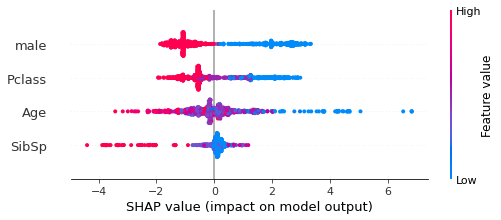

In [11]:
shap.plots.beeswarm(shap_values,show=False)

## Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP interaction values.

In [12]:
# Get SHAP interaction values
shap_interaction = explainer.shap_interaction_values(X)

SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 891 instances has a 4x4 matrix of SHAP interaction values

In [13]:
shap_interaction.shape

(891, 4, 4)

### Show mean absolute SHAP interaction values
Here we see the absolute mean of the SHAP interaction values for all of the instances.\
The values on the diagonal show the main effect for the feature, and the other values show the SHAP interaction for pairs of features (these are symetrical across the diagonal)

In [14]:
mean_abs_interactions = pd.DataFrame(
    np.abs(shap_interaction).mean(axis=(0)),
    index=X.columns, columns=X.columns)

mean_abs_interactions.round(2)

,male,Pclass,Age,SibSp
male,1.41,0.31,0.26,0.05
Pclass,0.31,0.81,0.22,0.04
Age,0.26,0.22,0.68,0.17
SibSp,0.05,0.04,0.17,0.25


### The proportion of SHAP that is from the interactions
#### Calculated from the absolute mean

In [15]:
total_shap = mean_abs_interactions.sum().sum()

interaction_shap = (mean_abs_interactions.sum().sum() - 
                    np.diagonal(mean_abs_interactions).sum().sum())

print(f'The proportion of the SHAP values coming from the interactions are: {interaction_shap/total_shap:0.3f}')

The proportion of the SHAP values coming from the interactions are: 0.400


### The proportion of SHAP that is from the interactions
#### Calculated per instance basis, shown as histogram

Text(0, 0.5, 'Number of instances')

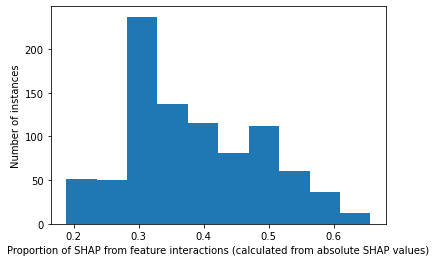

In [16]:
# sum each matrix to get a shap value per instance
abs_total_shap_per_instance = np.abs(shap_interaction).sum(axis=(1,2))

proportion_interaction = []
for i in range(abs_total_shap_per_instance.shape[0]):
    # sum just the off diagonals to get the feature interaction shap value per instance
    abs_interaction = (abs_total_shap_per_instance[i] - 
                       np.diagonal(np.abs(shap_interaction[i])).sum())
    proportion_interaction.append(
                abs_interaction / abs_total_shap_per_instance[i])

plt.hist(proportion_interaction);
plt.xlabel("Proportion of SHAP from feature interactions (calculated from absolute SHAP values)")
plt.ylabel("Number of instances")

### Represent the SHAP interaction matrix as histograms showing the distribution of all of the instance values

ACTION: Currently hardcoded in the ylim (0, 800). Write code to set this maximum value automatically

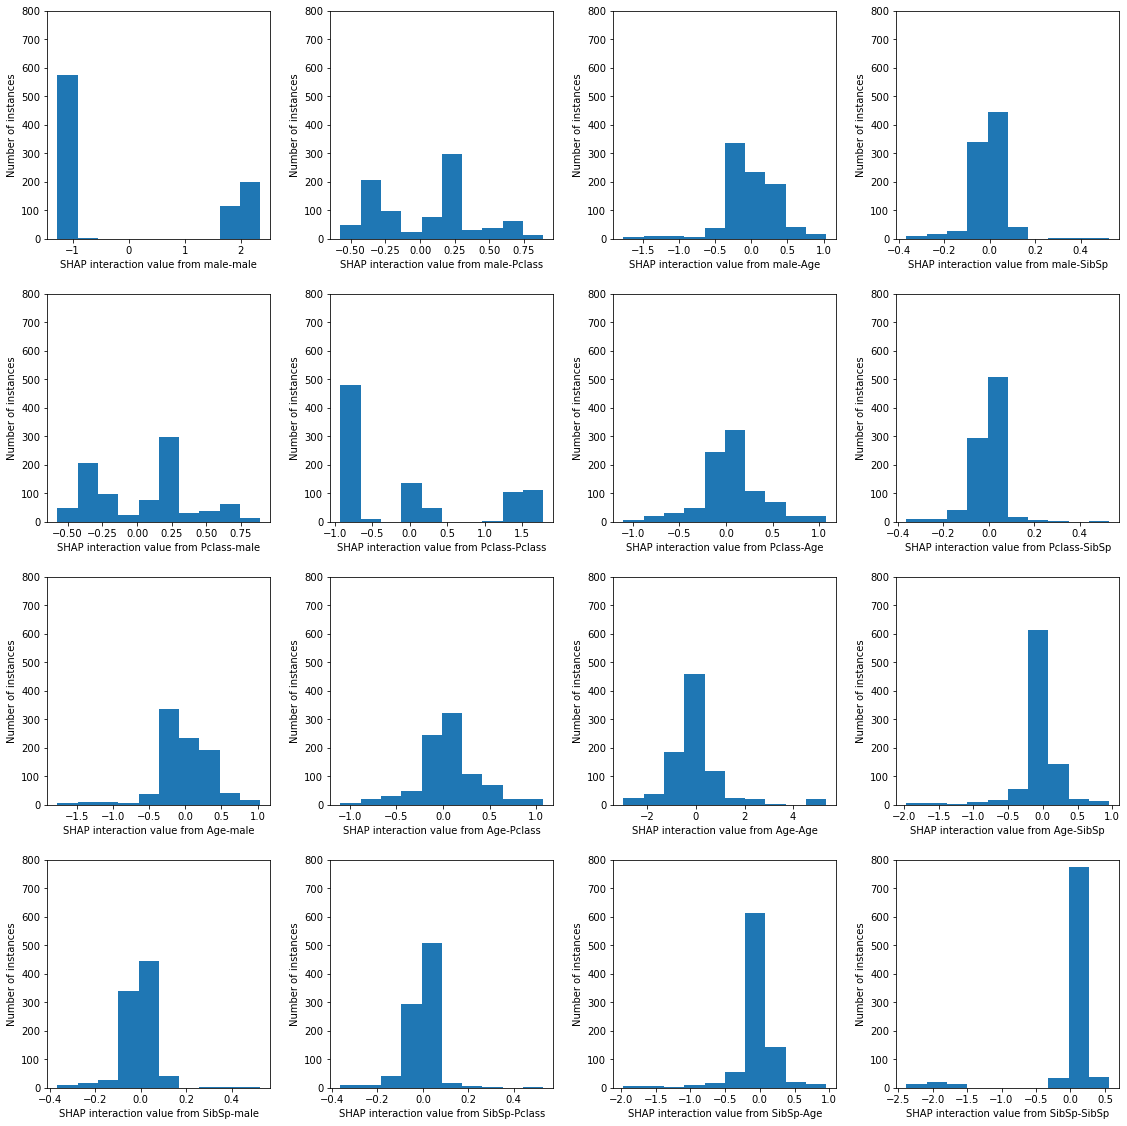

In [17]:
features = ["male","Pclass","Age","SibSp"]

fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()

count = 0
n_features = len(features)
for i in range(n_features):
    for j in range(n_features):    
        ax=axes[count]
        ax.hist(shap_interaction[:,i,j])#, ax=axes[count]);
        ax.set_xlabel(f"SHAP interaction value from {features[i]}-{features[j]}")
        ax.set_ylabel("Number of instances")
        ax.set_ylim(0, 800)
        count += 1
        
fig.set_figheight(16)
fig.set_figwidth(16)
plt.tight_layout(pad=2)
#fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()



## Show a worked example for a single instance

In [18]:
instance = 0
target_category = ["not survive", "survive"]
# Show data for first example
print ('Showing a worked example for the first instance')
print ('==============================================')
print ()
print ('------------------')
print ('Feature data values')
print ('------------------')
print (X.iloc[instance])

# Model output
prob_survive = y_proba[instance][1]
logodds_survive = np.log(prob_survive/(1 -prob_survive))
print ()
print ('-------------------')
print ('Model output values')
print ('-------------------')
print (f'1. Model probability [not survive, survive]: ' +
       f'{np.round(y_proba[instance],3)}')
##print ('------------')
#print (np.round(y_proba[instance],3))
print (f'\n2. Model log odds survive: {round(logodds_survive,3)}')
#print ('------------')
#print(round(logodds_survive,3))
cat = np.int(y_pred[instance])
print (f'\n3. Model classification: {cat} ({target_category[cat]})')
##print ('------------')
#print (y_pred[instance])

print ()
print ('-----------------')
print ('SHAP base value (log odds)')
print ('---------------')
print (shap_values.base_values[instance])
print ('\nNote: This is the same value for all of the instances. This is the ' +
       'models best guess without additional knowledge about the instance')
 
#example_shap = pd.DataFrame(shap_values.values[instance],columns=X.columns)
print ()
print ('-----------------')
print ('SHAP values (log odds)')
print ('------------')
# print (example_shap)
v = shap_values.values[instance][0]
print (f'{X.columns.values[0]}: {v:0.3f}')
v = shap_values.values[instance][1]
print (f'{X.columns.values[1]}: {v:0.3f}')
v = shap_values.values[instance][2]
print (f'{X.columns.values[2]}: {v:0.3f}')
v = shap_values.values[instance][3]
print (f'{X.columns.values[3]}: {v:0.3f}')
# print (shap_values.values[instance])
v = shap_values.values[instance].sum()
print (f'Total = {v:0.3f}')

print ('\nNote: These are patient dependent')
#print ()
#print ('-----------------')
#print ('Sum of SHAP values')
#print ('------------')
#print (shap_values.values[instance].sum())

print (f'\nThe "Model log odds survive" value ({logodds_survive:0.3g}, ' +
       f'see above) is calculated by adding up the SHAP base value ' +
       f'({shap_values.base_values[instance]:0.3f}, see above) with ' +
       f'all of the SHAP values for each feature ' +
       f'({shap_values.values[instance].sum():0.3f}, see above)')
print (f'{shap_values.base_values[instance]:0.3f} + ' +
       f'{shap_values.values[instance].sum():0.3f} = ' +
       f'{logodds_survive:0.3f}')

# SHAP interaction values for first employee
example_interaction = pd.DataFrame(shap_interaction[instance],
                                   index=X.columns,columns=X.columns)
row_total = example_interaction.sum(axis=0)
column_total = example_interaction.sum(axis=1)
total = example_interaction.sum().sum()
example_interaction['Total'] = row_total
example_interaction.loc['Total'] = column_total
example_interaction.loc['Total']['Total'] = total

print ()
print ('-----------------')
print ('SHAP interactions (log odds)')
print ('-----------------')
print ('\n* Each instance has a different SHAP value for the features. This ' +
       'is because the model is also capturing the interaction between pairs ' +
       'of features, and how that contributes to the features SHAP value.')
print ('* Each feature has a SHAP main effect (on the diagonal) and a SHAP ' +
       'interaction effect with each of the other features (off the diagonal)')
print ('* SHAP interaction is split symetrically, eg. age-male is the same ' +
       'as male-age.')
print ('* For each feature, the sum of the SHAP main effect and all of its ' +
       'SHAP interaction values = SHAP value for the feature (shown in ' +
       '"Total", and can be compared to the SHAP values above)')
print ()
print (example_interaction)

print ('------------------')
print ('\nThe model prediction for each instance can be arrived at by ' +
       'starting at the SHAP base value, and adding on the SHAP values from ' +
       'all of the the main effects (one per feature) and from all of the ' +
       'SHAP interactions (two per pair of features).')

Showing a worked example for the first instance

------------------
Feature data values
------------------
male       1.0
Pclass     3.0
Age       22.0
SibSp      1.0
Name: 0, dtype: float64

-------------------
Model output values
-------------------
1. Model probability [not survive, survive]: [0.865 0.135]

2. Model log odds survive: -1.856

3. Model classification: 0 (not survive)

-----------------
SHAP base value (log odds)
---------------
-0.5855415

Note: This is the same value for all of the instances. This is the models best guess without additional knowledge about the instance

-----------------
SHAP values (log odds)
------------
male: -0.954
Pclass: -0.458
Age: -0.195
SibSp: 0.337
Total = -1.270

Note: These are patient dependent

The "Model log odds survive" value (-1.86, see above) is calculated by adding up the SHAP base value (-0.586, see above) with all of the SHAP values for each feature (-1.270, see above)
-0.586 + -1.270 = -1.856

-----------------
SHAP interaction

## Show the sum of all of the SHAP interactions adds up to the log odds of predicted P for all instances

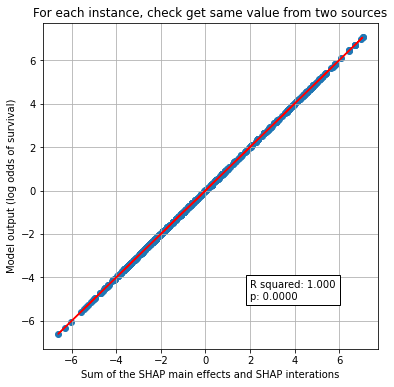

In [19]:
# Model output: probability survive
prob_survive = y_proba[:,1]
# Calculate log odds
logodds_survive = np.log(prob_survive/(1 -prob_survive))

# sum each matrix to get a value per instance
total_shap_per_instance = shap_values.base_values + shap_interaction.sum(axis=(1,2))

x = total_shap_per_instance
y = logodds_survive

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)


# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(2, -5, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel("Sum of the SHAP main effects and SHAP interations")
ax1.set_ylabel("Model output (log odds of survival)")
plt.title("For each instance, check get same value from two sources")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

# Histogram of total SHAP

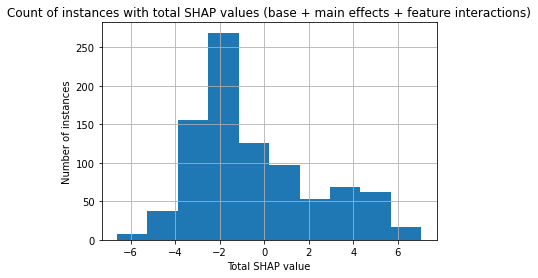

In [20]:
plt.hist(total_shap_per_instance)
plt.xlabel("Total SHAP value")
plt.ylabel("Number of instances")
plt.title("Count of instances with total SHAP values (base + main effects + feature interactions)")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

## Show how the main effect varies across the instances

For this example lets focus on the feature "male". This feaute has two possible values: males and females

We can see from the violin plot that the main effect (male-male) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

This means that the feature will contribute a strong likelihood of survival if the instance is female, and a mid-strong likelihood of not surviving if the instance is male.

In [21]:
def plot_violin_male_shap_interaction(main_feature, interaction_feature):
    category_list = ["female","male"]
    male_main_female = []
    male_main_male = []

    for i in range(X.shape[0]):
        gender = X.iloc[i]["male"]

        # SHAP interaction values for first employee
        example_interaction = pd.DataFrame(
            shap_interaction[i],index=X.columns,columns=X.columns)
        if gender == 1: #male
            male_main_male.append(
                example_interaction.loc[main_feature][interaction_feature])
        else: #female
            male_main_female.append(
                example_interaction.loc[main_feature][interaction_feature])

    # Set violin width relative to count of instances
    male_width = len(
        male_main_male)/(len(male_main_male)+len(male_main_female))
    female_width = len(
        male_main_female)/(len(male_main_male)+len(male_main_female))
    width = [female_width, male_width]

    shap_per_category = []

    s1 = pd.Series(male_main_female)
    s2 = pd.Series(male_main_male)

    shap_per_category.append(s1)
    shap_per_category.append(s2)
    #[male_main_male, male_main_female]
    # create violin plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.violinplot(shap_per_category, showmedians=True, widths=width, )#0.9)
    # Add line at Shap = 0
    #n_violins = 2
    #ax.plot([0, n_violins], [0,0],c='0.5')  
    # customise the axes
    ax.set_title("")
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=90, fontsize=12)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(
        f'SHAP interaction value for {main_feature}-{interaction_feature}',
        fontsize=12)
    ax.set_xlabel(f' {main_feature}', fontsize=12)

    plt.subplots_adjust(bottom=0.15, wspace=0.05)

    # Add line at Shap = 0
    n_violins = 3
    ax.plot([0, n_violins], [0,0],c='0.5')
    
    return()

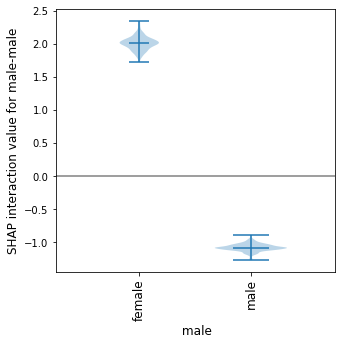

In [22]:
plot_violin_male_shap_interaction("male", "male");

We can also see the range of the SHAP interaction value between the features male-Pclass (divided by the male categories).

This shows that for females the SHAP interaction value between male-Pclass ranges from -0.6 to 0.9, and for males it has a smaller range (-0.6 to 0.3). Since this is in addition to the main effect (for which all females had a strong likelihood to survive), for some females their likelihood for surviving is further increased, whereas for others their likelihood for surviving is reduced.

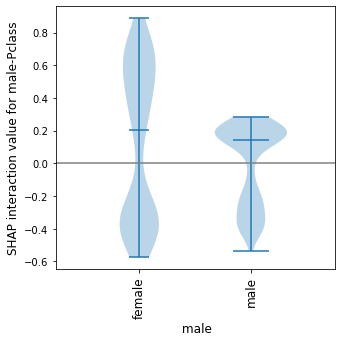

In [23]:
plot_violin_male_shap_interaction("male", "Pclass");

What this chart does not provide is an indication of the relationship of the Pclass values on the spread of values for each category.

This can be provided using a shap dependency plot - we will use the same data and represent these two violin plots as shap dependency plots.

## Detailed SHAP interactions using dependence plots
### Male - male interaction: SHAP main effect of male

We can see from the violin plot that the main effect (male-male) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

This means that the feature will contribute a strong likelihood of survival if the instance is female, and a mid-strong likelihood of not surviving if the instance is male.

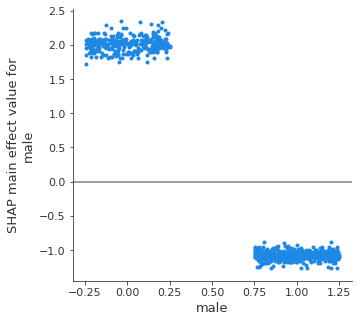

In [24]:
fig = plt.figure()
ax = fig.add_subplot()
shap.dependence_plot(
    ("male", "male"),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X["male"].nunique()
ax.plot([-1, n_violins], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(5)

Show male-Pclass SHAP interaction.

Note: The SHAP interaction for two features (e.g. male-Pclass) is splt between male-Pclass and Pclass-male. The total SHAP interaction is therefore 2* the individual interactions. We could multiply the interation by 2 to get the full SHAP interaction. Here we will plot both permutations and acknowledge that it's the sum of the pair (LHS shows columns as male and colour as Pclass. RHS shows columns as Pclass and colour as male). Each graph contains the exact same data points, and it is possible to match up the identical block of data points across the graphs.

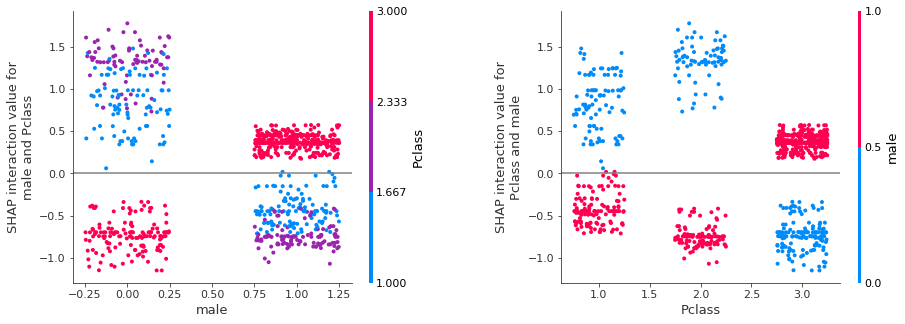

In [25]:
fig = plt.figure()
ax = fig.add_subplot(121)
shap.dependence_plot(
    ("male", "Pclass"),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X["male"].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

ax1 = fig.add_subplot(122)
shap.dependence_plot(
    ("Pclass", "male"),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax1,
    show=False)

# Add line at Shap = 0
n_classes = X["Pclass"].nunique()
ax1.plot([-1, n_classes + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=.4)

## Grid of SHAP dependence plots

We will now show all of the SHAP interaction values in a grid of plots.

Each row and column represents a feature.

The diagonal graphs show the SHAP main effect for each feature. The SHAP interactions between features are off the diagonal, these are split symetrically (eg. age-male == male-age).

The SHAP main effect for feature male is shown in the top left (position [1, 1]). As already discussed, this shows that when the feature value is female, this has a strong contribution to the models prediction that the passenger will survive. And when this feature value is male there is a mid-strong contribution that the passenger will not survive.

The plot in position [2,2] shows the SHAP main effect for class. This shows that first class contributes a strong likelihood to survive, second class does not have much contribution, and third class contributes a strong likelihood not to survive.

But on top of these main effects we can see the contributon from the interation of these features. This is shown in positions [1, 2] and [2, 1]. The SHAP interaction between male and Pclass, and Pclass and male.

Graph in grid position [1, 2] shows the SHAP interaction between male and Pclass, the data has been split into columns by the value of the gender feature (female on left, male on right), and the colour represents the class feature (first class = blue, second class = purple, third class = red). The value represents the contribution to the likelihood of this passenger surviving due to this combination of values - this is in addition to the main effect that we saw in the top left.

It can be seen that passengers in first or second class further increase the likelihood of survival for females, and not surviving for males, as the SHAP interation value is in the same sign to the SHAP main effect: A female passenger in first or second class will increase the likelihood of survival from the models prediction, and so will further help your survival in addition to the fact that you are female (as we saw in the SHAP main effect); similarly a male passenger in first or second class will increase the likelihood of not surviving, and so will further contribute to the likelihood that you will not survive, in addition to the fact that you are male (as we saw in the SHAP main effect).
However the converse is true for passengers in third class, as the SHAP interation value is in the opposite sign to the SHAP main effect. A female passenger in third class will have a negative contribution to the survival (but remember that the main effect for female is a strong likelihood to survive), and if you are male in third class this combination will have a positive contribution to your survival (but remember that the main effect for female is a mid-strong likelihood to not survive).

The grid of dependency graphs are a mirror image across the diagonal. Meaning that the same data is shown in position [1,2] as in [2,1] just with the feature being displayed in the column or by colour is switched over.

Looking at the graph in the first column on the second row this shows the identical SHAP interation values for the features male - PClass, as we have just discussed above. Now the columns are per class (first, second, third) and the colour is by gender (male, female).
Here we see that for first and second class females contributes that there is a mid likelihood to not survive, whereas if male then contributes a positive likelihood to survive. But that this is opposite for third class, where is it the females (red) with a positive likelihood to survive.

This is also on top of the main effect from Pclass.

Resources used to make the grid of dependence plots: https://stackoverflow.com/questions/58510005/python-shap-package-how-to-plot-a-grid-of-dependence-plots \
(for future reference, not used here: https://gist.github.com/eddjberry/3c1818a780d3cb17390744d6e215ba4d)

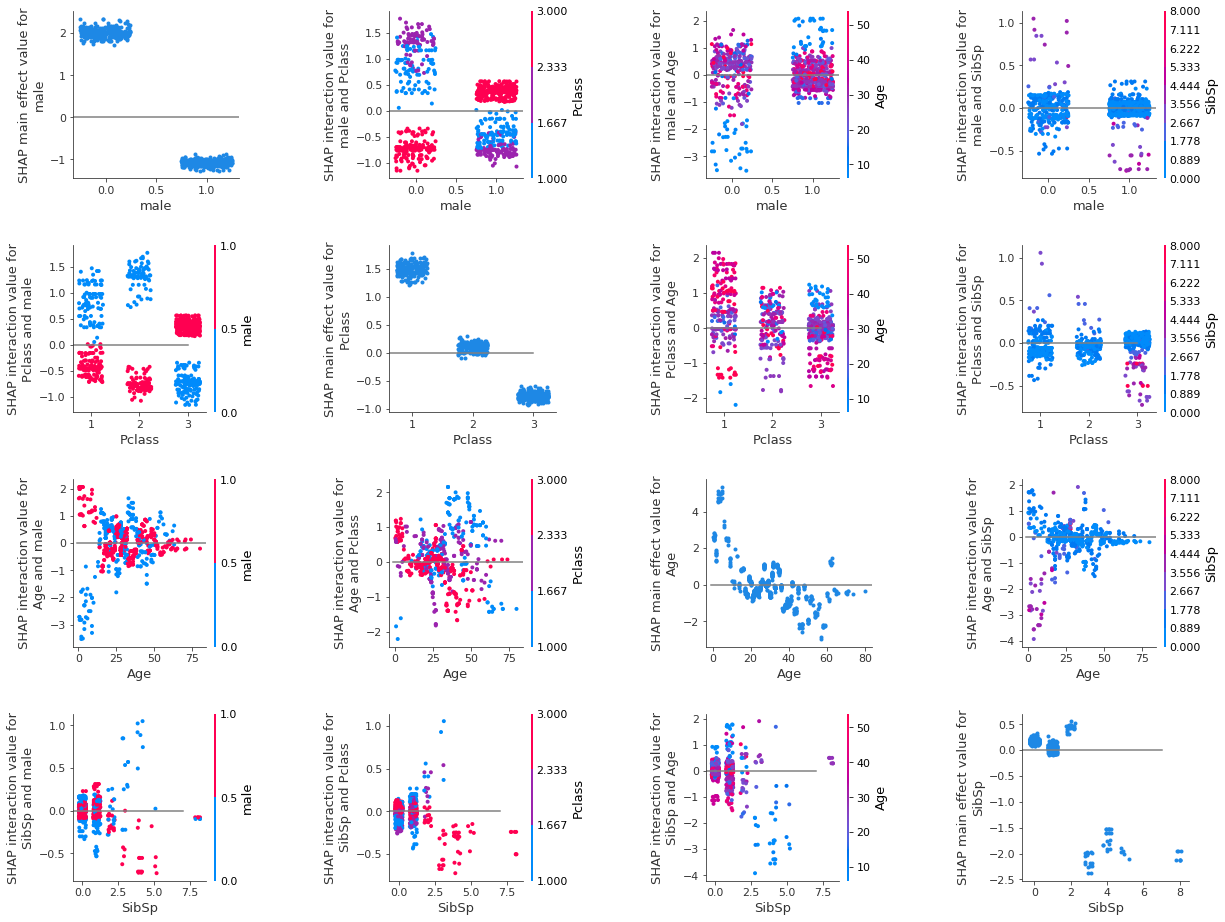

In [26]:
features = ["male","Pclass","Age","SibSp"]

fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()

count = 0
for f1 in features:
    for f2 in features:
        shap.dependence_plot(
            (f1, f2), shap_interaction, X, x_jitter=0.5, display_features=X,
            show=False, ax=axes[count])
        # Add line at Shap = 0
        n_classes = X[f1].nunique()
        axes[count].plot([-1, n_classes], [0,0],c='0.5')   
        count += 1
        
fig.set_figheight(16)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

Using the individual instance values you can unpick and understand how each instance gets their classification. Each instance is represented in the gridof SHAP depencency plots, and so this shows all of the relationships that the model uses to derive it's predictions for the whole dataset. 

## Other SHAP plotting options

The SHAP library also offers other plotting options, such as the beeswarm plot (and a summary plot based on the beeswarm plot). 

We will show them here for completeness, however we found them tricky to interprete, and they left gaps holes in our understanding of the relationships (left us with further questions). It was due to this that we created our grid of dependency plots.

### SHAP interactions summary plot (a grid of beeswarms)

The beeswarm plot above showed the overall SHAP value for the feature. This next plot (a grid of beeswarms) shows the SHAP main effect and SHAP interactions for each feature. Each row and column represents a feature. The beeswarms on the diagonal represent the SHAP main effect for that feature, and those off the diagonal represent the SHAP interations with the other features.


The graphs are symmetrical around the diagonal, and so the shape of the data in the corresponding graph about the diagonal are the same, however the points are coloured based on the value of the feature represented by the row. For example, the first row this showing the feature male, so red represents the value male, and blue represents the value female. The second row shows the feature Pclass where blue represents first class, purple represents second class, and red represents third class. The third row shows the feature Age where blue represents the youngest, purple represent middle aged and red represents oldest. The fourth row shows the feature SibSp where blue represents no siblings, purple represents 3-4 siblings, and red represents seven siblings.## Observations

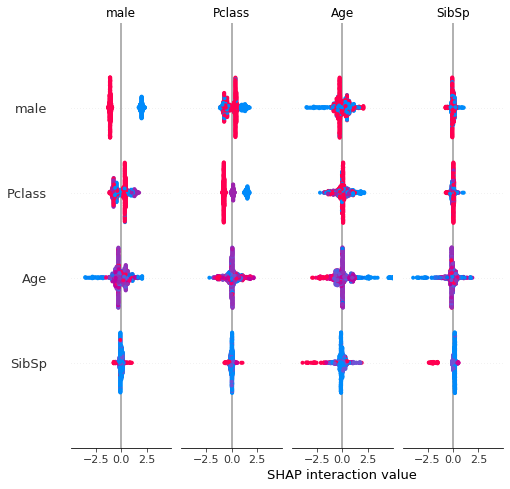

In [27]:
#Display summary plot
shap.summary_plot(shap_interaction, X,show=False)

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.